## Install and Import the required packages

In [ ]:
!pip install pandas_market_calendars
!pip install seaborn
!pip install torch
!pip install tensordict
!pip install torchrl
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install tqdm
!pip install mujoco
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.7/191.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
import os
import pandas as pd
import pandas_market_calendars as mcal
import locale
import math
from typing import Optional
import gymnasium as gym
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (
    Compose,
    DoubleToFloat,
    ObservationNorm,
    StepCounter,
    TransformedEnv
)
from torchrl.envs.libs.gym import GymEnv, GymWrapper
from torchrl.envs import ParallelEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm
import seaborn as sns

## Load datasets and process columns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

vendas = pd.read_csv('/content/drive/MyDrive/Datasets/vendas_dataset.csv')
compras = pd.read_csv('/content/drive/MyDrive/Datasets/compras_dataset.csv')
locale.setlocale(locale.LC_NUMERIC, '')

vendas = vendas.dropna(subset=["Quantidade", "Valor Líquido"])
compras = compras.dropna(subset=["Quantidade", "Valor Líquido"])


vendas['Dt. Operação'] = pd.to_datetime(vendas['Dt. Operação'])
vendas['Vencimento'] = pd.to_datetime(vendas['Vencimento'])
compras['Dt. Operação'] = pd.to_datetime(compras['Dt. Operação'])

vendas["Quantidade"] = vendas["Quantidade"].astype(str).replace(",","", regex=True).astype(float)
vendas["Valor Líquido"] =vendas["Valor Líquido"].astype(str).replace(",","", regex=True).astype(float)
vendas["Preço"] =vendas["Preço"].astype(str).replace(",","", regex=True).astype(float)

compras["Quantidade"] = compras["Quantidade"].astype(str).replace(",","", regex=True).astype(float)
compras["Valor Líquido"] = compras["Valor Líquido"].astype(str).replace(",","", regex=True).astype(float)
compras["Preço"] = compras["Preço"].astype(str).replace(",","", regex=True).astype(float)

vendas['DI'] = vendas['DI'].str.replace('%', '').astype(float) / 100

vendas['UniqueID'] = vendas['Cód. Cliente'] + '_' + vendas['Dt. Operação'].astype(str) + '_' + vendas['Cód. Título'] + '_' + vendas['Cód. Corretora']
compras['UniqueID'] = compras['Cód. Cliente'] + '_' + compras['Dt. Operação'].astype(str) + '_' + compras['Cód. Título'] + '_' + compras['Cód. Corretora']
df_vendas_final = vendas.drop(['Cód. Cliente', 'Cód. Título', 'Cód. Corretora', 'Tipo'], axis=1)
df_compras_final = compras.drop(['Cód. Cliente', 'Cód. Título','Vencimento', 'Cód. Corretora', 'Tipo', 'Dt. Liquidação'], axis=1)

<ipython-input-30-73deb7776dc1>:4: DtypeWarning: Columns (6,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  compras = pd.read_csv('/content/drive/MyDrive/Datasets/compras_dataset.csv')


In [ ]:
df_vendas_final = df_vendas_final[df_vendas_final["Dt. Operação"] != df_vendas_final["Vencimento"]]

### Create Purchases and Future Terms groups

In [ ]:
df_vendas_grouped = df_vendas_final.groupby("UniqueID")
df_compras_grouped = df_compras_final.groupby("UniqueID")

## Auxiliary Functions

In [ ]:
brazil_calendar = mcal.get_calendar('BMF')

# Calculates the rentability
def calc_rent(buy_value, sell_value, du_idx, di_rent):
  buy_sell_rent = (sell_value / buy_value) - 1
  rent_anual = (1 + buy_sell_rent) ** du_idx - 1
  rent_over_cdi = rent_anual / di_rent
  return rent_over_cdi

def calc_du_idx(start_date,end_date):
  time_frame = brazil_calendar.schedule(start_date, end_date)
  date_range = mcal.date_range(time_frame, frequency='1D')
  return 252 / (len(date_range) - 1)

def get_random_sell(sell_group):
    random_sell_group_key = random.choice(list(sell_group.groups.keys()))
    random_sell_group = sell_group.get_group(random_sell_group_key).reset_index()
    random_sell_id = random.randint(0, len(random_sell_group) - 1)
    return random_sell_group.iloc[random_sell_id]

def get_random_sell_group(groups):
    random_sell_group_key = random.choice(list(groups.groups.keys()))
    random_sell_group = groups.get_group(random_sell_group_key).reset_index()
    return random_sell_group

# Calculates the expected price to reach 100% CDI
def calc_expected_price(v, du_idx, di):
      return round((v / pow(di+1, safe_division(1,du_idx))), 5)

def get_expected_price(operation_dt, expiration_dt, sell_price, di ):
    du = calc_du_idx(operation_dt, expiration_dt)
    return round((sell_price / pow(di+1, safe_division(1, du))), 5)

def safe_division(a, b):
    if b == 0:
        return 0
    return a / b

## Scoring Function

In [ ]:
def sig(x):
    return 1 / (1 + math.exp(-x))

def cac_score(expected_price, avg_price):
    """
    Calculates the CAC (Customer Acquisition Cost) score based on the expected price and average price.

    Parameters:
    - expected_price (float): The expected price.
    - avg_price (float): The average price.

    Returns:
    - final_score (float): The CAC score.

    The CAC score is calculated as the sum of two components:
    - Delta Score: The difference between the expected price and the average price.
    - Expected Average Rate Score: The ratio of the average price to the expected price.

    If the delta is greater than or equal to 0, the delta score is calculated as (expected_price - delta),
    otherwise it is calculated as delta.

    If the expected average rate is less than or equal to 1, the expected average rate score is equal to the
    expected average rate, otherwise it is 0.

    The final CAC score is the sum of the delta score and the expected average rate score.
    """
    delta = expected_price - avg_price
    expected_avg_rate = avg_price / expected_price
    delta_score = (expected_price - delta) if delta >= 0 else delta
    sig_delta_score = sig(delta_score)
    expected_avg_rate_score = expected_avg_rate if expected_avg_rate <= 1 else 0
    final_score = sig_delta_score + expected_avg_rate_score
    return final_score

## Environment Model

In [ ]:
class MatchEnv(gym.Env):
    def __init__(self, table_vendas_grouped, table_compras_grouped):
        self.sells_grouped = table_vendas_grouped # Grouped selling transactions
        self.purchases_grouped = table_compras_grouped # Grouped buying transactions

        # Define action and observation spaces
        self.action_space = gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32)

        # Initialize internal state variables
        self.sell_remaining_space_rate = 0
        self.sell_expected_price = 0
        self.purchases_avg_price = 0
        self.current_purchase_price = 0
        self.current_purchase_qty = 0
        self.current_purchase_score = 0
        self.current_purchase_price_diff = 0

        # More internal state initializations
        self.iter = 0
        self.sell_iter = 0
        self.sell_remaining_space = 0
        self.current_sell = None
        self.current_purchase_group = None
        self.used_purchases = [] # Tracks used purchase transactions - {"id": number "qty": number}
        self.purchases_total_price = 0
        self.sell_max_qty = 0
        self.old_price_diff = 0

        self.picked_sell_group = None

        self.done = False # Indicates if the environment should reset
        self.avg_rent = 0
        self.avg_deviation = 0
        self.rent_store = []
        self.reset() # Reset environment at the start

    def pick_current_purchase(self,purchase_id, quantity):
        # Logic to select a purchase based on ID and adjust quantities
        purchase = self.current_purchase_group.loc[purchase_id]
        purchase_id = purchase.name
        available_qty = purchase["remaining_qty"]
        quantity = min(quantity, available_qty)
        purchase_remaining_qty = purchase["remaining_qty"] - quantity
        self.current_purchase_group.loc[purchase_id, "remaining_qty"] = purchase_remaining_qty
        self.sell_remaining_space -= quantity
        self.used_purchases.append({"id": purchase_id, "qty": quantity})
        return quantity

    def get_state(self) -> np.array:
        # Define the current state representation
        return np.array([
            self.sell_remaining_space_rate,
            self.sell_expected_price,
            self.purchases_avg_price,
            self.current_purchase_price_diff,
            self.current_purchase_qty,
            self.current_purchase_score
        ], dtype=np.float32)

    def update_state(self, quantity):
        # Update state variables after a purchase
        self.purchases_total_price += self.current_purchase_price * quantity
        self.purchases_avg_price = safe_division(self.purchases_total_price, (self.sell_max_qty - self.sell_remaining_space))
        self.sell_remaining_space_rate = safe_division(self.sell_remaining_space, self.sell_max_qty)
        du = calc_du_idx(self.current_sell["Dt. Operação"], self.current_sell["Vencimento"])
        self.avg_rent = calc_rent(self.purchases_avg_price, self.current_sell["Preço"], du, self.current_sell["DI"]) if self.purchases_avg_price > 0 else 0
        return self.get_state()

    def get_reward(self):
        # Calculate reward based on price differences and rent deviations
        price_difference = abs(self.sell_expected_price - self.purchases_avg_price)
        mean_cdi = sum(self.rent_store) / len(self.rent_store) if len(self.rent_store) > 0 else 0
        rent_difference = abs((mean_cdi * 100) - 100) * 0.1
        price_scale = 20
        rent_scale = 1.5
        deviation_scale = 10

        reward = 0
        reward += (-price_scale * pow(price_difference, 2)) + (-rent_scale * pow(rent_difference, 2))


        deviations = [abs(x - mean_cdi) for x in self.rent_store]
        deviation_avg = sum(deviations) / len(deviations) if len(deviations) > 0 else 0

        return reward - pow(deviation_avg, 2)



    def step(self, action):
        # Perform an environment step based on action
        current_purchase_idx = self.iter % len(self.current_purchase_group) if self.iter > 0 else 0
        quantity_percentage = action[0]
        quantity = int(self.current_purchase_qty  * quantity_percentage)
        quantity = min(quantity, self.sell_remaining_space)

        quantity = self.pick_current_purchase(current_purchase_idx, quantity)

        state = self.update_state(quantity)
        reward = self.get_reward()

        self.iter += 1
        next_purchase_id = self.iter % len(self.current_purchase_group) if self.iter > 0 else 0
        current_purchase = self.current_purchase_group.iloc[next_purchase_id]
        self.current_purchase_price = current_purchase["Preço"]
        self.current_purchase_qty = current_purchase["remaining_qty"]
        self.current_purchase_score = current_purchase["score"]

        if abs(self.current_purchase_price - self.sell_expected_price) < self.old_price_diff:
            reward += 0.1
        elif abs(self.current_purchase_price - self.sell_expected_price) == 0:
            reward += 1
        elif  abs(self.current_purchase_price - self.sell_expected_price) > self.old_price_diff:
            reward -= 0.1

        self.old_price_diff = self.current_purchase_price - self.sell_expected_price

        if self.sell_remaining_space == 0:
            self.rent_store.append(self.avg_rent)
            self.avg_rent = 0
            if self.sell_iter < len(self.picked_sell_group) - 1:
              self.sell_iter += 1
              self.next_sell(self.sell_iter, next_purchase_id)
            else:
              self.done = True

        return  state, reward, self.done, False, {"info": "info"}

    def next_sell(self, next_sell_id, next_purchase_id):
        # Prepare next sell operation
        self.current_sell = self.picked_sell_group.iloc[next_sell_id]

        current_purchase = self.current_purchase_group.iloc[next_purchase_id]
        self.current_purchase_price = current_purchase["Preço"]
        self.current_purchase_qty = current_purchase["remaining_qty"]
        self.current_purchase_score = current_purchase["score"]

        self.used_purchases = []
        self.purchases_total_price = 0
        self.sell_max_qty = self.current_sell["Quantidade"]
        self.sell_expected_price = get_expected_price(self.current_sell["Dt. Operação"], self.current_sell["Vencimento"], self.current_sell["Preço"], self.current_sell["DI"])
        self.current_purchase_group["score"] = self.current_purchase_group.apply(lambda x: cac_score(self.sell_expected_price, x["Preço"]), axis=1)

        self.sell_remaining_space = self.sell_max_qty
        self.purchases_avg_price = 0
        self.current_purchase_price = current_purchase["Preço"]
        self.current_purchase_qty = current_purchase["Quantidade"]
        self.current_purchase_score = current_purchase["score"]
        self.current_purchase_price_diff = self.current_purchase_price - self.sell_expected_price
        self.sell_remaining_space_rate = self.sell_remaining_space / self.sell_max_qty
        self.old_price_diff = np.inf


    def reset(self, seed: Optional[int] = None):
        # Reset environment states for a new episode
        self.iter = 0
        self.sell_iter = 0
        self.avg_deviation = 0
        self.rent_store = []

        self.picked_sell_group = get_random_sell_group(self.sells_grouped)
        self.current_sell = self.picked_sell_group.iloc[self.sell_iter]
        self.used_purchases = []
        self.purchases_total_price = 0
        self.sell_max_qty = self.current_sell["Quantidade"]
        self.sell_expected_price = get_expected_price(self.current_sell["Dt. Operação"], self.current_sell["Vencimento"], self.current_sell["Preço"], self.current_sell["DI"])
        self.current_purchase_group = self.purchases_grouped.get_group(self.current_sell["UniqueID"]).reset_index(drop=True)
        self.current_purchase_group["score"] = self.current_purchase_group.apply(lambda x: cac_score(self.sell_expected_price, x["Preço"]), axis=1)

        self.current_purchase_group["remaining_qty"] = self.current_purchase_group["Quantidade"]

        self.current_purchase_group = self.current_purchase_group.sample(frac=1).reset_index(drop=True)#self.current_purchase_group.sort_values(by="score", ascending=False, ignore_index=True)
        current_purchase = self.current_purchase_group.iloc[self.iter]

        self.sell_remaining_space = self.sell_max_qty
        self.purchases_avg_price = 0
        self.current_purchase_price = current_purchase["Preço"]
        self.current_purchase_qty = current_purchase["Quantidade"]
        self.current_purchase_score = current_purchase["score"]
        self.current_purchase_price_diff = self.current_purchase_price - self.sell_expected_price
        self.sell_remaining_space_rate = self.sell_remaining_space / self.sell_max_qty
        self.old_price_diff = np.inf

        self.done = False

        return self.get_state(), {}

## Environment Instance

In [ ]:
is_fork = torch.multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
base_env = GymWrapper(MatchEnv(df_vendas_grouped, df_compras_grouped), device=device)

### Normalize Observations

In [ ]:
from warnings import filterwarnings
filterwarnings("ignore")  # Ignore warnings to keep output clean

# Set up an environment with transformations for reinforcement learning
env = TransformedEnv(
    base_env,  # Base environment to apply transformations
    Compose(
        ObservationNorm(in_keys=["observation"]),  # Normalize observations
        DoubleToFloat(),  # Convert data type from double to float
        StepCounter(),  # Count steps in the environment
    ),
)

# Initialize statistics for observation normalization
env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)

## PPO Hyperparameters

In [ ]:
num_cells = 256  # number of cells in each layer i.e. output dim.
lr = 1e-5
max_grad_norm = 1.0
frames_per_batch = 1000
# For a complete training, bring the number of frames up to 1M
total_frames = 10_000 #10_000

# PPO
sub_batch_size = 128  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimisation steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-5

In [ ]:
check_env_specs(env)

2024-04-02 14:54:45,581 [torchrl][INFO] check_env_specs succeeded!


In [ ]:
rollout = env.rollout(3)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)
print("Reward of the rollout:", rollout["next", "reward"])

rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                observation: Tensor(shape=torch.Size([3, 6]), device=cuda:0, dtype=torch.float32, is_shared=True),
                reward: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                step_count: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.int64, is_shared=True),
                terminated: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                truncated: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True)},
            batch_size=torch.Size([3]),
 

### Actor Network

In [ ]:
# Actor network for action decision-making
actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)

# Wraps actor network to use in RL environments
policy_module = TensorDictModule(
    actor_net, 
    in_keys=["observation"],  # from environment observations
    out_keys=["loc", "scale"]  # for action distribution parameters
)

In [ ]:
policy_module = ProbabilisticActor(
    module=policy_module,  # underlying policy module providing base action values
    spec=env.action_spec,  # specification of action properties from the environment
    in_keys=["loc", "scale"],  # keys for location and scale parameters of the distribution
    distribution_class=TanhNormal,  # class of distribution to model actions
    distribution_kwargs={
        "min": env.action_spec.space.low,  # minimum bound of the action space
        "max": env.action_spec.space.high,  # maximum bound of the action space
    },
    return_log_prob=True,  # whether to return the logarithm of the probability along with the action
)

## Value Network

In [ ]:
# Defines a sequential neural network for calculating the value
value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)

value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)


## Experience Collector and Replay Buffer

In [ ]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        loc: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        observation: Tensor(shape=torch.Size([6]), device=cuda:0, dtype=torch.float32, is_shared=True),
        sample_log_prob: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.float32, is_shared=True),
        scale: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        step_count: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, is_shared=True),
        terminated: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        truncated: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True)},
    batch_size=torch.Size([]),
    device=cuda:0,
    is_sha

In [ ]:
# Create a data collector synchronized with the provided specifications
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

In [ ]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

## Define GAE

In [ ]:
# Initialize the Generalized Advantage Estimation (GAE) module to compute adjusted rewards.
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)

#  Setup the PPO loss module using a clipping mechanism to constrain policy updates.
loss_module = ClipPPOLoss(
    actor_network=policy_module,
    critic_network=value_module,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    critic_coef=1.0,
    loss_critic_type="smooth_l1",
)

# Configure the optimizer for training the model, using the Adam algorithm.
optim = torch.optim.Adam(loss_module.parameters(), lr)

# Use a cosine annealing learning rate scheduler to adjust the learning rate over time.
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)

## Training

In [ ]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optimization step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel())
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our ``env`` horizon).
        # The ``rollout`` method of the ``env`` can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_type(ExplorationType.MEAN), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(100000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()


 10%|█         | 1000/10000 [43:12<6:28:54,  2.59s/it]

 10%|█         | 1000/10000 [00:31<04:39, 32.25it/s]
eval cumulative reward: -44568.6094 (init: -44568.6094), eval step-count: 32, average reward=-2007.1042 (init=-2007.1042), step count (max): 122, lr policy:  0.0000:  10%|█         | 1000/10000 [00:32<04:39, 32.25it/s]
eval cumulative reward: -44568.6094 (init: -44568.6094), eval step-count: 32, average reward=-2007.1042 (init=-2007.1042), step count (max): 122, lr policy:  0.0000:  10%|█         | 1000/10000 [00:48<04:39, 32.25it/s]
eval cumulative reward: -44568.6094 (init: -44568.6094), eval step-count: 32, average reward=-2007.1042 (init=-2007.1042), step count (max): 122, lr policy:  0.0000:  20%|██        | 2000/10000 [01:03<04:14, 31.38it/s]
eval cumulative reward: -44568.6094 (init: -44568.6094), eval step-count: 32, average reward=-2031.6156 (init=-2007.1042), step count (max): 215, lr policy:  0.0000:  20%|██        | 2000/10000 [01:03<04:14, 31.38it/s]
eval cumulativ

KeyboardInterrupt: 

## Evaluation

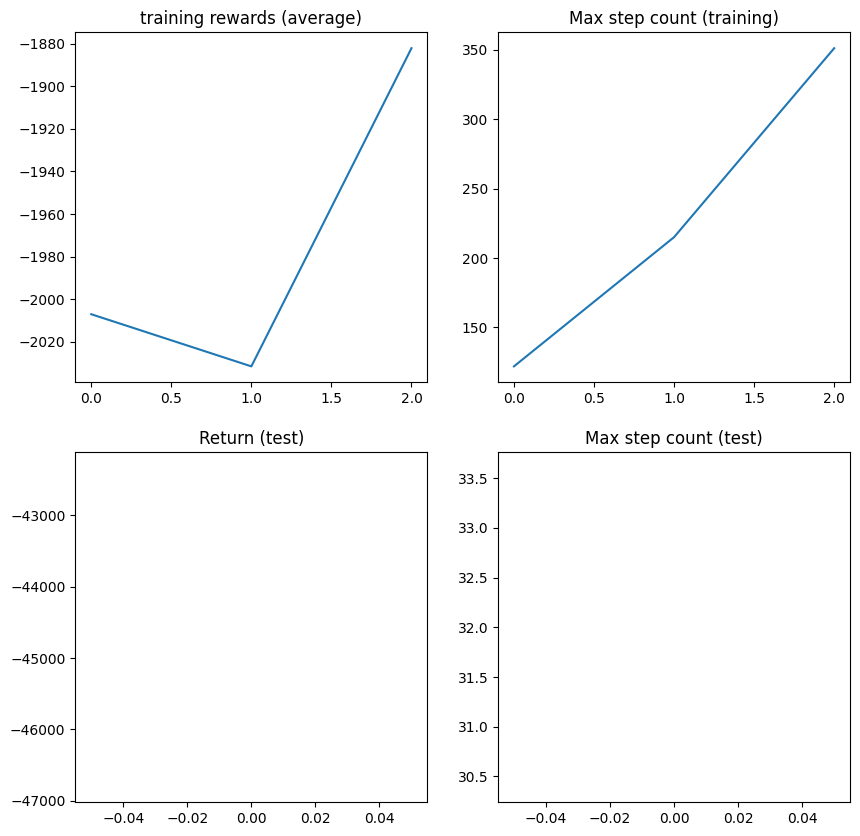

In [ ]:
plt.figure(figsize=(10, 10)),
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()

In [ ]:
df_vendas_grouped.get_group("Cliente 9_2023-12-21_MRVE3_STDE").head()

,Unnamed: 0,Chave,Dt. Operação,Tipo Operação,Quantidade,Preço,Valor Líquido,Vencimento,DI,UniqueID
9047,9047,4622A,2023-12-21,V,82800.0,10.79,893654.32,2024-08-01,0.1063,Cliente 9_2023-12-21_MRVE3_STDE
9048,9048,4623A,2023-12-21,V,77200.0,10.80,833985.40,2024-08-01,0.1063,Cliente 9_2023-12-21_MRVE3_STDE


In [ ]:
df_vendas_final.sort_values(by=["UniqueID"])

,Unnamed: 0,Chave,Dt. Operação,Tipo Operação,Quantidade,Preço,Valor Líquido,Vencimento,DI,UniqueID
1364,1364,B1366,2022-02-02,V,38397.0,7.57,290806.93,2022-03-31,0.1094,Cliente 100_2022-02-02_BKBR3_PLAN
1737,1737,B1739,2022-02-02,V,14944.0,18.93,282853.42,2022-08-04,0.1188,Cliente 100_2022-02-02_EZTC3_INDU
1789,1789,B1791,2022-02-02,V,7328.0,45.42,332848.18,2022-10-11,0.1208,Cliente 100_2022-02-02_GPAR3_INDU
1853,1853,B1855,2022-02-02,V,26579.0,11.56,307245.14,2023-03-28,0.1209,Cliente 100_2022-02-02_ITSA4_INDU
1942,1942,B1944,2022-02-02,V,76634.0,3.37,258529.54,2022-09-01,0.1200,Cliente 100_2022-02-02_LPSB3_PLAN
...,...,...,...,...,...,...,...,...,...,...
45152,45152,40727A,2023-06-14,V,268.0,116.09,31113.19,2023-07-14,0.1364,Cliente 9_2023-06-14_BOVA11_PACC
26878,26878,22453A,2023-06-16,V,6708.0,11.48,77022.92,2023-07-17,0.1364,Cliente 9_2023-06-16_GOLL4_XPIN
26879,26879,22454A,2023-06-16,V,2332.0,11.47,26753.31,2023-07-17,0.1364,Cliente 9_2023-06-16_GOLL4_XPIN
9048,9048,4623A,2023-12-21,V,77200.0,10.80,833985.40,2024-08-01,0.1063,Cliente 9_2023-12-21_MRVE3_STDE


### Evaluation for a single purchase

In [ ]:
"""
This code performs an evaluation of sales data using a gym environment.

It initializes a group of sales data for a specific client and date, and groups it by a unique identifier.
Then, it creates a GymWrapper object with a MatchEnv environment, using the sales data and another grouped dataset of purchases.
The code then runs a loop for 2 iterations, where it resets the environment, performs actions based on a policy module, and updates the state.
The loop continues until the environment is done.
After each iteration, it prints the average rent, used purchases, and remaining space for selling.
Finally, it calculates and prints the average of the average rents obtained in each iteration.
"""

evaluation_vendas = df_vendas_grouped.get_group("Cliente 9_2023-12-21_MRVE3_STDE").groupby("UniqueID")
new_env = GymWrapper(MatchEnv(evaluation_vendas, df_compras_grouped), device=device)

avg_rents_singular = []

for i in range(2):
    state = env.transform[0](new_env.reset())

    done = False
    while not done:
        action = policy_module(state)
        dt = new_env.step(action)
        # print(dt["next"]["observation"])
        state = env.transform[0](dt["next"])
        # print(new_env.sell_remaining_space)
        done = dt["done"]
    print(new_env.avg_rent,  new_env.used_purchases, new_env.sell_remaining_space)
    print(new_env.rent_store)
    print(sum(new_env.rent_store) / len(new_env.rent_store))
    avg_rents_singular.append(new_env.avg_rent)

print(sum(avg_rents_singular) / len(avg_rents_singular))

0 [{'id': 6, 'qty': 330}, {'id': 7, 'qty': 487}, {'id': 8, 'qty': 557}, {'id': 9, 'qty': 278}, {'id': 10, 'qty': 139}, {'id': 11, 'qty': 209}, {'id': 12, 'qty': 487}, {'id': 13, 'qty': 556}, {'id': 14, 'qty': 488}, {'id': 15, 'qty': 69}, {'id': 16, 'qty': 489}, {'id': 17, 'qty': 487}, {'id': 18, 'qty': 280}, {'id': 19, 'qty': 487}, {'id': 20, 'qty': 69}, {'id': 21, 'qty': 139}, {'id': 22, 'qty': 362}, {'id': 23, 'qty': 69}, {'id': 24, 'qty': 348}, {'id': 25, 'qty': 419}, {'id': 26, 'qty': 559}, {'id': 27, 'qty': 557}, {'id': 28, 'qty': 349}, {'id': 29, 'qty': 139}, {'id': 30, 'qty': 558}, {'id': 31, 'qty': 279}, {'id': 32, 'qty': 349}, {'id': 33, 'qty': 420}, {'id': 34, 'qty': 419}, {'id': 35, 'qty': 491}, {'id': 36, 'qty': 489}, {'id': 37, 'qty': 279}, {'id': 38, 'qty': 140}, {'id': 39, 'qty': 70}, {'id': 40, 'qty': 420}, {'id': 41, 'qty': 210}, {'id': 42, 'qty': 489}, {'id': 43, 'qty': 350}, {'id': 44, 'qty': 140}, {'id': 45, 'qty': 560}, {'id': 46, 'qty': 489}, {'id': 0, 'qty': 178}

In [ ]:
avg_rents = []
count = 0

# Iterate over each group in df_vendas_grouped
for group in df_vendas_grouped:
    # Get the first row of the group and group it by "UniqueID"
    sub_v_eval = df_vendas_grouped.get_group(group[0]).iloc[0:1].groupby("UniqueID")
    sub_c = df_compras_grouped
    
    # Create a GymWrapper object with MatchEnv, sub_v_eval, and sub_c
    curr_env = GymWrapper(MatchEnv(sub_v_eval, sub_c), device=device)

    state = curr_env.reset()
    done = False
    
    # Run the environment until done is True
    while not done:
        state = env.transform[0](state)
        action = policy_module(state)
        dt = curr_env.step(action)
        state = env.transform[0](dt["next"])
        done = dt["done"]
    
    print(curr_env.sell_remaining_space)
    avg_rents.append(curr_env.avg_rent * 100)
    count += 1
    print(f"{count}")
    
    # Break the loop if count reaches 100
    if count == 100:
        break

In [ ]:
import seaborn as sns

def plot_avg_rents(avg_rents):
    """
    Plots the distribution of average rents.

    Parameters:
    avg_rents (array-like): An array or list of average rents.

    Returns:
    None
    """
    sns.histplot(avg_rents, kde=True)
    plt.title('Distribution of Average Rents')
    plt.xlabel('Average Rent')
    plt.ylabel('Frequency')
    plt.show()
